# HBN Data Processing Pipeline

**Pipeline Overview:**
1. **Merge phenotype and diagnosis data** - Combine demographic info with clinical diagnoses
2. **Merge all data sources** - Combine NIH cognitive tests, Temporal Discounting tasks, and phenotype data
3. **Preprocess Temporal Discounting data** - Clean and engineer features from delay discounting measures
4. **Preprocess NIH Picture Sequence data** - Examine NIH Picture Sequence Memory test data
5. **Exploratory Data Analysis** - Build analysis-ready datasets and examine missingness

---

## Part 1: Merge Phenotype and Diagnosis Data

Download phenotype data from multiple HBN releases and merge it with clinical diagnosis information.

In [3]:
# Import all necessary libraries
from pathlib import Path
import os
import io
import re
import csv
import json
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set up folder structure
DATA = Path("data")
RAW = DATA / "raw"              # Raw downloaded files
INTERIM = DATA / "interim"      # Processed/merged files
PROCESSED = DATA / "processed"  # Final analysis-ready files
RESULTS = DATA / "results"      # Analysis results

# Create folders if they don't exist
for folder in [RAW, INTERIM, PROCESSED, RESULTS]:
    folder.mkdir(parents=True, exist_ok=True)

print("✓ Folder structure created")

✓ Folder structure created


### Helper Functions

In [4]:
def http_text(url, timeout=60):
    """Download text content from a URL."""
    # Force HTTP for this specific server to avoid certificate issues
    if url.startswith("https://fcon_1000.projects.nitrc.org"):
        url = url.replace("https://", "http://", 1)
    
    response = requests.get(url, timeout=timeout)
    response.raise_for_status()
    return response.text


def read_table_smart(url):
    """Download a CSV/TSV file and automatically detect the separator."""
    text = http_text(url)
    sample = text[:5000]
    
    try:
        # Try to automatically detect the delimiter
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample, delimiters=[",", ";", "\t", "|"])
        separator = dialect.delimiter
    except Exception:
        # If automatic detection fails, use comma as default
        separators = [",", ";", "\t", "|"]
        separator = max(separators, key=sample.count)
    
    df = pd.read_csv(io.StringIO(text), sep=separator, engine="python")
    df.columns = [col.strip() for col in df.columns]  # Clean column names
    
    return df


def normalize_eid(value):
    """Clean and standardize participant EID (e.g., 'NDAR AA075 AMK' → 'NDARAA075AMK')."""
    if pd.isna(value):
        return np.nan
    
    cleaned = str(value).strip().upper()
    cleaned = re.sub(r"[^A-Z0-9]", "", cleaned)  # Remove all non-alphanumeric
    
    return cleaned if cleaned else np.nan


def get_release_number(filename):
    """Extract release version number from filename (e.g., 'HBN_R10_Pheno.csv' → 10.0)."""
    match = re.search(r"_R(\d+)(?:_(\d+))?_Pheno\.csv$", filename)
    
    if not match:
        return 0.0
    
    major = int(match.group(1))
    minor = int(match.group(2)) if match.group(2) else 0
    
    return float(f"{major}.{minor}")

print("✓ Helper functions defined")

✓ Helper functions defined


### Download Phenotype Files

In [5]:
# Base URL for phenotype files
BASE = "http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/File/_pheno/"

# List of all phenotype files (Releases 1-11)
PHENO_FILES = [
    "HBN_R1_1_Pheno.csv",
    "HBN_R2_1_Pheno.csv",
    "HBN_R3_Pheno.csv",
    "HBN_R4_Pheno.csv",
    "HBN_R5_Pheno.csv",
    "HBN_R6_Pheno.csv",
    "HBN_R7_Pheno.csv",
    "HBN_R8_Pheno.csv",
    "HBN_R9_Pheno.csv",
    "HBN_R10_Pheno.csv",
    "HBN_R11_Pheno.csv"
]

pheno_frames = []

for filename in PHENO_FILES:
    url = BASE + filename
    
    try:
        print(f"Downloading {filename}...")
        df = read_table_smart(url)
        
        # Save to raw folder
        df.to_csv(RAW / filename, index=False)
        
        # Add tracking columns
        df["_release_file"] = filename
        df["_release_rank"] = get_release_number(filename)
        
        # Normalize participant ID
        if "EID" in df.columns:
            df["_EID"] = df["EID"].apply(normalize_eid)
        else:
            # Try to find an ID column
            id_column = next((col for col in df.columns 
                            if re.fullmatch(r"(participant_)?eid", col, flags=re.I)), None)
            if id_column:
                df["_EID"] = df[id_column].apply(normalize_eid)
            else:
                df["_EID"] = np.nan
        
        pheno_frames.append(df)
        print(f"  ✓ Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
        
    except Exception as e:
        print(f"  ✗ WARNING: Failed to load {filename}: {e}")

  ✓ Loaded: 797 rows, 9 columns
  ✓ Loaded: 256 rows, 9 columns
  ✓ Loaded: 317 rows, 9 columns
  ✓ Loaded: 558 rows, 9 columns
  ✓ Loaded: 391 rows, 9 columns
  ✓ Loaded: 336 rows, 9 columns
  ✓ Loaded: 692 rows, 9 columns
  ✓ Loaded: 470 rows, 9 columns
  ✓ Loaded: 422 rows, 9 columns
  ✓ Loaded: 847 rows, 9 columns
  ✓ Loaded: 1160 rows, 9 columns


### Combine and Deduplicate Phenotype Data

Combine all releases and keep only the latest data for each participant.

In [6]:
# Combine all releases
pheno_all = pd.concat(pheno_frames, ignore_index=True)
print(f"Combined all releases: {pheno_all.shape[0]} rows, {pheno_all.shape[1]} columns")

# Remove rows without a valid EID
pheno_all = pheno_all[pheno_all["_EID"].notna()]

# Keep only the LATEST row for each participant
pheno_all_sorted = pheno_all.sort_values(["_EID", "_release_rank"])
pheno_latest = pheno_all_sorted.drop_duplicates("_EID", keep="last")

print(f"Latest data (one row per participant): {pheno_latest.shape[0]} participants")

# Save both versions
pheno_all.to_csv(RAW / "HBN_pheno_all_concat.csv", index=False)
pheno_latest.drop(columns=["_release_file", "_release_rank"]).to_csv(
    RAW / "HBN_pheno_latest.csv", index=False
)

print("\n✓ Phenotype data saved successfully")

Combined all releases: 6246 rows, 10 columns
Latest data (one row per participant): 3432 participants

✓ Phenotype data saved successfully


### Load and Merge Diagnosis Data

Load the clinical diagnosis file and merge it with the phenotype data.

In [7]:
# Load diagnosis file (must be in data/raw/ folder)
DIAG_FILE = "Diagnosis_ClinicianConsensus.csv"
diag_path = RAW / DIAG_FILE

diag = pd.read_csv(diag_path, low_memory=False)
print(f"✓ Loaded diagnosis file: {diag.shape[0]} rows, {diag.shape[1]} columns")

✓ Loaded diagnosis file: 4766 rows, 164 columns


In [8]:
# Create a set of known participant IDs for matching
known_eids = set(pheno_latest["_EID"].dropna().unique())
print(f"We have {len(known_eids)} known participant IDs from phenotype data")


def extract_eid_from_identifiers(identifier_value, known_ids):
    """Try to find a valid participant ID from the Identifiers field."""
    if pd.isna(identifier_value):
        return np.nan
    
    text = str(identifier_value).upper()
    tokens = re.split(r"[;,|\s]+", text)
    
    # Strategy 1: Look for exact matches to known IDs
    for token in tokens:
        cleaned_token = normalize_eid(token)
        if cleaned_token in known_ids:
            return cleaned_token
    
    # Strategy 2: Look for HBN-style IDs using pattern matching
    match = re.search(r"\bHBN[A-Z0-9]+\b", text)
    if match:
        cleaned_token = normalize_eid(match.group(0))
        if cleaned_token in known_ids:
            return cleaned_token
    
    return np.nan


# Extract EIDs from the diagnosis data
diag = diag.copy()
diag["_EID"] = diag["Identifiers"].apply(
    lambda val: extract_eid_from_identifiers(val, known_eids)
)

# Keep only rows where we successfully extracted an EID
diag_with_eid = diag[diag["_EID"].notna()]
diag_keyed = diag_with_eid.drop_duplicates("_EID")

print(f"✓ Successfully matched {diag_keyed.shape[0]} participants")
print(f"  (out of {diag.shape[0]} total diagnosis records)")

We have 3432 known participant IDs from phenotype data
✓ Successfully matched 3373 participants
  (out of 4766 total diagnosis records)


In [9]:
# Merge phenotype and diagnosis data
merged = pheno_latest.merge(
    diag_keyed,
    on="_EID",
    how="inner",  # Keep only participants in BOTH datasets
    suffixes=("_pheno", "_dx")
)

print(f"✓ Merged dataset: {merged.shape[0]} participants, {merged.shape[1]} columns")

# Preview the merged data
base_cols = ["_EID", "Sex", "Age"]
dx_cols = [c for c in merged.columns if "DX_" in c][:8]
preview_cols = [c for c in (base_cols + dx_cols) if c in merged.columns]

print("\nPreview of merged data:")
merged[preview_cols].head(10)

✓ Merged dataset: 3373 participants, 174 columns

Preview of merged data:


,_EID,Sex,Age,"Diagnosis_ClinicianConsensus,DX_01","Diagnosis_ClinicianConsensus,DX_01_ByHx","Diagnosis_ClinicianConsensus,DX_01_Cat","Diagnosis_ClinicianConsensus,DX_01_Code","Diagnosis_ClinicianConsensus,DX_01_Confirmed","Diagnosis_ClinicianConsensus,DX_01_New","Diagnosis_ClinicianConsensus,DX_01_PRem","Diagnosis_ClinicianConsensus,DX_01_Past_Doc"
0,NDARAA075AMK,1.0,6.728040,No Diagnosis Given,0.0,No Diagnosis Given,No Diagnosis Given,NaN,0.0,0.0,NaN
1,NDARAA112DMH,0.0,5.545744,ADHD-Combined Type,0.0,Neurodevelopmental Disorders,F90.2,NaN,0.0,0.0,NaN
2,NDARAA117NEJ,0.0,7.475929,ADHD-Combined Type,0.0,Neurodevelopmental Disorders,F90.2,NaN,1.0,0.0,NaN
3,NDARAA306NT2,1.0,21.216746,Generalized Anxiety Disorder,0.0,Anxiety Disorders,NaN,1.0,NaN,NaN,NaN
4,NDARAA504CRN,1.0,9.165297,ADHD-Inattentive Type,0.0,Neurodevelopmental Disorders,F90.0,1.0,NaN,NaN,NaN
5,NDARAA536PTU,0.0,11.998402,ADHD-Inattentive Type,0.0,Neurodevelopmental Disorders,F90.0,NaN,0.0,0.0,NaN
6,NDARAA947ZG5,0.0,13.627880,ADHD-Combined Type,0.0,Neurodevelopmental Disorders,F90.2,1.0,NaN,NaN,NaN
7,NDARAA948VFH,1.0,7.982660,ADHD-Combined Type,0.0,Neurodevelopmental Disorders,F90.2,NaN,0.0,0.0,NaN
8,NDARAB055BPR,1.0,10.793862,ADHD-Combined Type,0.0,Neurodevelopmental Disorders,F90.2,1.0,NaN,NaN,NaN
9,NDARAB348EWR,0.0,5.805384,Other Specified Depressive Disorder,0.0,Depressive Disorders,F32.8,1.0,NaN,NaN,NaN


In [10]:
# Save merged phenotype + diagnosis data
merged_path = INTERIM / "HBN_pheno_with_diagnosis.csv"
merged.to_csv(merged_path, index=False)
print(f"✓ Saved merged dataset to: {merged_path}")

✓ Saved merged dataset to: data/interim/HBN_pheno_with_diagnosis.csv


---

## Part 2: Merge Master Data (NIH + Temporal Discounting + Phenotype)

Merge the NIH cognitive test data and Temporal Discounting task data with phenotype+diagnosis file.

### Load Raw Data Files

In `data/raw/` folder:
- `NIH_final.csv`
- `Temp_Disc_Final.csv`

In [11]:
# Load the three main data sources
read_opts = dict(
    dtype=str, 
    keep_default_na=True, 
    na_values=["", "NA", "NaN"], 
    low_memory=False
)

nih = pd.read_csv(RAW / "NIH_final.csv", **read_opts)
td = pd.read_csv(RAW / "Temp_Disc_Final.csv", **read_opts)
ph = pd.read_csv(INTERIM / "HBN_pheno_with_diagnosis.csv", **read_opts)

print(f"NIH:        {nih.shape}")
print(f"Temp Disc:  {td.shape}")
print(f"Pheno+Dx:   {ph.shape}")

NIH:        (3879, 64)
Temp Disc:  (2506, 115)
Pheno+Dx:   (3373, 174)


### Detect and Normalize EID Columns

Different files may have different column names for participant IDs. We'll standardize them.

In [12]:
def detect_eid_col(df):
    """Find the participant ID column even if the header is unusual."""
    cols = list(df.columns)
    
    # Check if header contains 'EID' anywhere
    for c in cols:
        if "EID" in str(c).upper():
            return c
    
    # Look for values that look like NDAR IDs
    def looks_like_ndar(s):
        s = s.astype(str).str.upper()
        return s.str.startswith("NDAR").mean()
    
    best_c, best_score = None, 0.0
    for c in cols:
        try:
            score = looks_like_ndar(df[c])
            if score > best_score:
                best_c, best_score = c, score
        except Exception:
            pass
    
    if best_score >= 0.5:
        return best_c
    
    return None


def normalize_id(s):
    """Normalize participant IDs."""
    return (s.astype(str)
            .str.replace("\ufeff", "", regex=False)
            .str.upper().str.strip()
            .str.replace(r"[^A-Z0-9]", "", regex=True))


# Detect and normalize EID columns for all three datasets
for name, df in [("NIH", nih), ("TempDisc", td), ("PhenoDx", ph)]:
    eid_col = detect_eid_col(df)
    if eid_col is None:
        raise KeyError(f"{name}: could not find an EID column")
    
    if eid_col != "EID":
        df.rename(columns={eid_col: "EID"}, inplace=True)
    
    df["_EID"] = normalize_id(df["EID"])
    print(f"{name}: detected EID column = '{eid_col}', unique IDs = {df['_EID'].nunique()}")

NIH: detected EID column = 'NIH_final,EID', unique IDs = 3879
TempDisc: detected EID column = 'assessment Temp_Disc_Final,EID', unique IDs = 2506
PhenoDx: detected EID column = 'EID', unique IDs = 3373


### Check Overlaps Between Datasets

In [13]:
set_nih = set(nih["_EID"].dropna())
set_td = set(td["_EID"].dropna())
set_ph = set(ph["_EID"].dropna())

print("Overlap NIH ∩ TD:", len(set_nih & set_td))
print("Overlap NIH ∩ PhenoDx:", len(set_nih & set_ph))
print("Overlap TD  ∩ PhenoDx:", len(set_td & set_ph))
print("Overlap all three:", len(set_nih & set_td & set_ph))

Overlap NIH ∩ TD: 2430
Overlap NIH ∩ PhenoDx: 2923
Overlap TD  ∩ PhenoDx: 2097
Overlap all three: 2076


### Merge All Three Datasets

In [14]:
# Prepare datasets for merging (remove duplicate _EID columns)
td_left = td.loc[:, ["_EID"] + [c for c in td.columns if c not in ("EID", "_EID")]]
nih_right = nih.loc[:, ["_EID"] + [c for c in nih.columns if c not in ("EID", "_EID")]]

# Get demographics from phenotype data
ph_slim = ph.loc[:, ["_EID", "Sex", "Age"]].drop_duplicates("_EID")

# Perform the merge
master = (td_left.merge(nih_right, on="_EID", how="inner", suffixes=("_td", "_nih"))
                 .merge(ph_slim, on="_EID", how="inner"))

print(f"✓ Master dataset shape: {master.shape}")

# Save the merged master file
out_csv = INTERIM / "NIH_TempDisc_pheno.csv"
master.to_csv(out_csv, index=False)
print(f"✓ Saved: {out_csv}")

✓ Master dataset shape: (2076, 180)
✓ Saved: data/interim/NIH_TempDisc_pheno.csv


### Check Missingness in Merged Data

In [15]:
# Calculate column-wise missing percentages
missing_pct = master.isna().mean()

# Drop columns that are 100% missing
drop_cols = missing_pct[missing_pct == 1.0].index.tolist()
master_nz = master.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} columns with 100% missing.")

# Recompute missingness
miss = master_nz.isna().mean().sort_values(ascending=False)
miss_df = pd.DataFrame({"column": miss.index, "missing_pct": miss.values})

# Create 10% bins for missingness
bins = np.arange(0, 1.01, 0.1)
labels = [f"{int(b*100)}–{int((b+0.1)*100)}%" for b in bins[:-1]]
miss_df["bin"] = pd.cut(
    miss_df["missing_pct"], 
    bins=bins, 
    labels=labels, 
    include_lowest=True, 
    right=False
)

# Show top 20 most-missing columns
print("\nTop 20 most-missing columns:")
miss_df.assign(missing_pct=lambda d: (d["missing_pct"]*100).round(1)).head(20)

Dropped 10 columns with 100% missing.

Top 20 most-missing columns:


,column,missing_pct,bin
0,"NIH_final,NIH_Picture_Vocab_Rescored",100.0,90–100%
1,"NIH_final,NIH_Processing_Rescored",98.9,90–100%
2,"NIH_final,NIH_Picture_Seq_Inst_Breakoff",98.7,90–100%
3,"NIH_final,NIH_Picture_Seq_Age_Corr_Stnd",98.7,90–100%
4,"NIH_final,NIH_Picture_Seq_Computed_Score",98.7,90–100%
5,"NIH_final,NIH_Picture_Seq_Uncorr_Stnd",98.7,90–100%
6,"NIH_final,NIH_Picture_Seq_Raw",98.7,90–100%
7,"NIH_final,NIH_Picture_Seq_Itm_Cnt",98.7,90–100%
8,"NIH_final,NIH_Picture_Seq_Inst_Status",98.7,90–100%
9,"NIH_final,NIH_Picture_Vocab_Inst_Status",98.6,90–100%


---

## Part 3: Preprocess Temporal Discounting Data

Clean the Temporal Discounting (delay discounting) data and create analysis-ready features.

In [16]:
# Load the merged master file
MASTER = INTERIM / "NIH_TempDisc_pheno.csv"
df = pd.read_csv(MASTER, low_memory=False)
print(f"Loaded: {df.shape}")

Loaded: (2076, 180)


### Find Temporal Discounting Columns

The column names have long prefixes, so find them by their suffixes.

In [17]:
def find_col(df, tail):
    """Find a column by its ending (suffix)."""
    tail_low = tail.lower()
    cands = [c for c in df.columns
             if c.lower().endswith(tail_low) or c.split(",")[-1].strip().lower() == tail_low]
    print(f"{tail}: {cands[:3] if len(cands) > 3 else cands}")
    return cands[0] if cands else None


# Find the key TD columns
k1 = find_col(df, "Temp_Disc_run1_k")
k2 = find_col(df, "Temp_Disc_run2_k")
ed1 = find_col(df, "Temp_Disc_run1_ed50")
ed2 = find_col(df, "Temp_Disc_run2_ed50")

key_cols = [c for c in [k1, k2, ed1, ed2] if c is not None]
assert len(key_cols) > 0, "No TD columns detected—check the file headers."

Temp_Disc_run1_k: ['assessment Temp_Disc_Final,Temp_Disc_run1_k']
Temp_Disc_run2_k: ['assessment Temp_Disc_Final,Temp_Disc_run2_k']
Temp_Disc_run1_ed50: ['assessment Temp_Disc_Final,Temp_Disc_run1_ed50']
Temp_Disc_run2_ed50: ['assessment Temp_Disc_Final,Temp_Disc_run2_ed50']


### Examine Missingness in TD Data

In [18]:
# Coerce to numeric
df[key_cols] = df[key_cols].apply(pd.to_numeric, errors="coerce")

# Calculate missingness
miss_tbl = (
    df[key_cols].isna()
    .agg(["sum", "mean"]).T
    .rename(columns={"sum": "n_missing", "mean": "missing_pct"})
    .assign(
        n_rows=len(df),
        n_present=lambda x: x.n_rows - x.n_missing
    )
    .sort_values("missing_pct", ascending=False)
)

print("Missingness in TD columns:")
miss_tbl

Missingness in TD columns:


,n_missing,missing_pct,n_rows,n_present
"assessment Temp_Disc_Final,Temp_Disc_run2_k",63.0,0.030347,2076,2013.0
"assessment Temp_Disc_Final,Temp_Disc_run2_ed50",63.0,0.030347,2076,2013.0
"assessment Temp_Disc_Final,Temp_Disc_run1_k",46.0,0.022158,2076,2030.0
"assessment Temp_Disc_Final,Temp_Disc_run1_ed50",46.0,0.022158,2076,2030.0


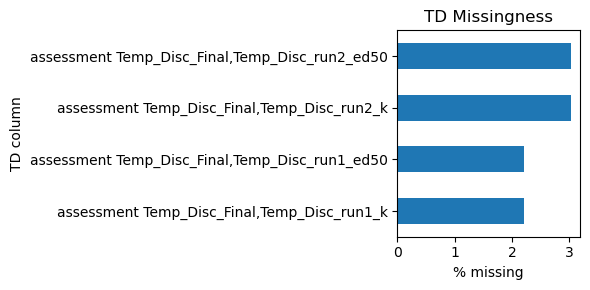

In [19]:
# Visualize missingness
(miss_tbl["missing_pct"] * 100).sort_values().plot(kind="barh", figsize=(6, 3))
plt.xlabel("% missing")
plt.ylabel("TD column")
plt.title("TD Missingness")
plt.tight_layout()
plt.show()

### Clean Column Names

In [20]:
# Create short, clean names
rename_map = {}
if k1:  rename_map[k1] = "k1"
if k2:  rename_map[k2] = "k2"
if ed1: rename_map[ed1] = "ed50_1"
if ed2: rename_map[ed2] = "ed50_2"

df = df.rename(columns=rename_map)


def to_num(s):
    """Convert column to numeric, handling commas and spaces."""
    return pd.to_numeric(
        s.astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
        .replace({"": np.nan, "NA": np.nan, "null": np.nan}),
        errors="coerce"
    )


# Convert to numeric
for c in ["k1", "k2", "ed50_1", "ed50_2"]:
    if c in df.columns:
        df[c] = to_num(df[c])

print("First few rows:")
df[["k1", "k2", "ed50_1", "ed50_2"]].head()

First few rows:


,k1,k2,ed50_1,ed50_2
0,0.000110,0.000110,9131.250000,9131.250000
1,0.039552,0.000279,25.283196,3578.704514
2,0.000279,0.000110,3578.704514,9131.250000
3,0.000129,0.000612,7748.122555,1633.447658
4,0.013412,0.004742,74.562468,210.894506


### Validate Data: Check Relationship Between k and ED50

In delay discounting theory, ED50 ≈ 1/k (both in days). Let's verify this.

In [21]:
# Check: (1/k) should be close to ed50
for kcol, dcol in [("k1", "ed50_1"), ("k2", "ed50_2")]:
    if kcol in df.columns and dcol in df.columns:
        ok = df[kcol].gt(0) & df[dcol].notna()
        ratio = (1.0 / df.loc[ok, kcol]) / df.loc[ok, dcol]
        print(f"Median((1/{kcol})/{dcol}) = {np.nanmedian(ratio):.10f}")
        # Should be very close to 1.0 if data is valid

Median((1/k1)/ed50_1) = 1.0000000001
Median((1/k2)/ed50_2) = 1.0000000010


### Create Derived Features

In [22]:
# --- helpers ---
def first_col(df, candidates):
    """Return the first existing column name from candidates (or None)."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def safe_log_series(s):
    s = pd.to_numeric(s, errors="coerce")
    s = s.where(s > 0)          # invalid/zero -> NaN
    return np.log(s)

# --- resolve column names (add/adjust aliases if needed) ---
k1_col   = first_col(df, ["k1", "Temp_Disc_run1_k", "run1_k"])
k2_col   = first_col(df, ["k2", "Temp_Disc_run2_k", "run2_k"])
ed1_col  = first_col(df, ["ed50_1", "Temp_Disc_run1_ed50", "run1_ed50"])
ed2_col  = first_col(df, ["ed50_2", "Temp_Disc_run2_ed50", "run2_ed50"])

# --- logs of k (for geometric means & robust diffs) ---
logk1 = safe_log_series(df[k1_col]) if k1_col else pd.Series(index=df.index, dtype=float)
logk2 = safe_log_series(df[k2_col]) if k2_col else pd.Series(index=df.index, dtype=float)

# Geometric mean of k (via mean of logs)
if k1_col or k2_col:
    df["logk_mean"] = pd.concat([logk1, logk2], axis=1).mean(axis=1, skipna=True)
    df["k_gmean"]   = np.exp(df["logk_mean"])                 # geometric mean of k
else:
    df["logk_mean"] = np.nan
    df["k_gmean"]   = np.nan

# ED50 from k_gmean (ED50 = 1/k)
df["ed50_from_k"] = 1.0 / df["k_gmean"]

# Optional: geometric mean of ED50 if you have both ed50 columns
if ed1_col or ed2_col:
    loged1 = safe_log_series(df[ed1_col]) if ed1_col else None
    loged2 = safe_log_series(df[ed2_col]) if ed2_col else None
    df["ed50_gmean"] = np.exp(pd.concat([loged1, loged2], axis=1).mean(axis=1, skipna=True))
else:
    df["ed50_gmean"] = np.nan

# --- consistency metrics ---
# raw absolute difference (heteroskedastic on k scale)
if k1_col and k2_col:
    df["k_abs_diff"] = (pd.to_numeric(df[k1_col], errors="coerce") -
                        pd.to_numeric(df[k2_col], errors="coerce")).abs()
    # log-absolute difference (scale-invariant)
    df["k_abs_diff_log"] = (logk1 - logk2).abs()
    # relative difference (CV-style)
    k1v = pd.to_numeric(df[k1_col], errors="coerce")
    k2v = pd.to_numeric(df[k2_col], errors="coerce")
    df["k_cv"] = (k1v - k2v).abs() / ((k1v + k2v) / 2)
else:
    df["k_abs_diff"]     = np.nan
    df["k_abs_diff_log"] = np.nan
    df["k_cv"]           = np.nan

# --- peek ---
feat_cols = [c for c in [
    k1_col, k2_col,
    "k_gmean", "logk_mean",
    ed1_col, ed2_col, "ed50_from_k", "ed50_gmean",
    "k_abs_diff", "k_abs_diff_log", "k_cv"
] if c in df.columns]
display(df[feat_cols].head())

,k1,k2,k_gmean,logk_mean,ed50_1,ed50_2,ed50_from_k,ed50_gmean,k_abs_diff,k_abs_diff_log,k_cv
0,0.000110,0.000110,0.000110,-9.119458,9131.250000,9131.250000,9131.252625,9131.250000,0.000000,0.000000,0.000000
1,0.039552,0.000279,0.003324,-5.706448,25.283196,3578.704514,300.800595,300.800744,0.039273,4.952615,1.971939
2,0.000279,0.000110,0.000175,-8.651107,3578.704514,9131.250000,5716.469446,5716.471429,0.000170,0.936703,0.873733
3,0.000129,0.000612,0.000281,-8.176825,7748.122555,1633.447658,3557.542258,3557.548684,0.000483,1.556754,1.303548
4,0.013412,0.004742,0.007975,-4.831498,74.562468,210.894506,125.398628,125.398624,0.008670,1.039721,0.955185


### Save Processed Data with TD Features

In [23]:
# Save back to interim folder with TD features included
OUT = INTERIM / "NIH_TempDisc_pheno_withTD.csv"
df.to_csv(OUT, index=False)
print(f"✓ Saved: {OUT}")

✓ Saved: data/interim/NIH_TempDisc_pheno_withTD.csv


---

## Part 4: Preprocess NIH Picture Sequence Memory Data

Examine the NIH Picture Sequence Memory test data.

In [24]:
# Load the master file with TD features
df = pd.read_csv(INTERIM / "NIH_TempDisc_pheno_withTD.csv", low_memory=False)
print(f"Loaded: {df.shape}")

Loaded: (2076, 187)


### Identify Picture Sequence Memory Columns

In [25]:
# Find all Picture Sequence columns
prefix = "NIH_final,NIH_Picture_Seq_"
ps_cols = [c for c in df.columns if c.startswith(prefix)]

print(f"Found {len(ps_cols)} Picture Sequence columns:")
for c in ps_cols:
    print(" •", c)

Found 8 Picture Sequence columns:
 • NIH_final,NIH_Picture_Seq_Age_Corr_Stnd
 • NIH_final,NIH_Picture_Seq_Computed_Score
 • NIH_final,NIH_Picture_Seq_Inst_Breakoff
 • NIH_final,NIH_Picture_Seq_Inst_Status
 • NIH_final,NIH_Picture_Seq_Itm_Cnt
 • NIH_final,NIH_Picture_Seq_Raw
 • NIH_final,NIH_Picture_Seq_Rescored
 • NIH_final,NIH_Picture_Seq_Uncorr_Stnd


### Check Missingness in Picture Sequence Data

In [26]:
# Per-column missingness
col_missing = (
    df[ps_cols].isna()
    .agg(["sum", "mean"])
    .T.rename(columns={"sum": "n_missing", "mean": "missing_pct"})
)
col_missing["n_rows"] = len(df)
col_missing["n_present"] = col_missing["n_rows"] - col_missing["n_missing"]
col_missing = col_missing.sort_values("missing_pct", ascending=False)

print("Missingness in Picture Sequence columns:")
col_missing

Missingness in Picture Sequence columns:


,n_missing,missing_pct,n_rows,n_present
"NIH_final,NIH_Picture_Seq_Rescored",2076.0,1.000000,2076,0.0
"NIH_final,NIH_Picture_Seq_Age_Corr_Stnd",2048.0,0.986513,2076,28.0
"NIH_final,NIH_Picture_Seq_Computed_Score",2048.0,0.986513,2076,28.0
"NIH_final,NIH_Picture_Seq_Inst_Breakoff",2048.0,0.986513,2076,28.0
"NIH_final,NIH_Picture_Seq_Inst_Status",2048.0,0.986513,2076,28.0
"NIH_final,NIH_Picture_Seq_Itm_Cnt",2048.0,0.986513,2076,28.0
"NIH_final,NIH_Picture_Seq_Raw",2048.0,0.986513,2076,28.0
"NIH_final,NIH_Picture_Seq_Uncorr_Stnd",2048.0,0.986513,2076,28.0


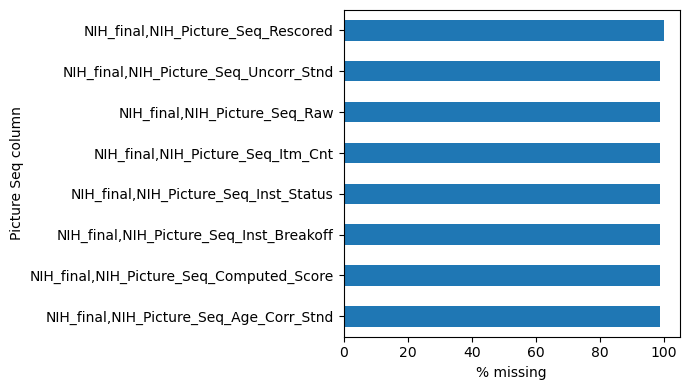

In [27]:
# Visualize missingness
ax = (col_missing["missing_pct"] * 100).sort_values().plot(kind="barh", figsize=(7, 4))
ax.set_xlabel("% missing")
ax.set_ylabel("Picture Seq column")
plt.tight_layout()
plt.show()

### Per-Participant Completeness

How many participants have complete vs. missing Picture Sequence data?

In [28]:
# Calculate fraction of missing PS fields per participant
row_missing_frac = df[ps_cols].isna().mean(axis=1)
row_bins = pd.cut(
    row_missing_frac, 
    bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    right=False
)
row_summary = row_bins.value_counts().sort_index().rename("n_participants").to_frame()
row_summary["pct_participants"] = row_summary["n_participants"] / len(df)

print("Per-participant completeness:")
row_summary

Per-participant completeness:


,n_participants,pct_participants
"[0.0, 0.1)",0,0.000000
"[0.1, 0.2)",28,0.013487
"[0.2, 0.3)",0,0.000000
"[0.3, 0.4)",0,0.000000
"[0.4, 0.5)",0,0.000000
"[0.5, 0.6)",0,0.000000
"[0.6, 0.7)",0,0.000000
"[0.7, 0.8)",0,0.000000
"[0.8, 0.9)",0,0.000000
"[0.9, 1.0)",0,0.000000


In [29]:
# List participants with ALL PS fields missing
eid_col = next((c for c in df.columns if c.endswith("_EID") or c == "_EID" or c == "EID"), None)

if eid_col:
    all_missing_idx = row_missing_frac.eq(1.0)
    print(f"Participants with ALL PS fields missing: {int(all_missing_idx.sum())}")

Participants with ALL PS fields missing: 2048


#### Picture Sequence Data currently not usable

---

## Part 5: Master Sheet Preprocessing

In [30]:
# Load the fully processed data
df = pd.read_csv(INTERIM / "NIH_TempDisc_pheno_withTD.csv", low_memory=False)
print(f"Loaded: {df.shape}")

Loaded: (2076, 187)


### Drop Columns with ≥90% Missing

In [31]:
# Calculate missingness
col_missing = df.isna().mean()

# Identify columns to drop
hard_drop = col_missing[col_missing >= 0.90].index.tolist()
df1 = df.drop(columns=hard_drop)

print(f"Dropped {len(hard_drop)} columns with ≥90% missing")
print(f"Remaining shape: {df1.shape}")

Dropped 26 columns with ≥90% missing
Remaining shape: (2076, 161)


### Build Feature Tiers

Organize features by missingness level:
- **Core features**: ≤20% missing
- **Extended features**: 20-40% missing

In [32]:
# Define feature tiers
core_cols = col_missing[(col_missing <= 0.20)].index.tolist()
extended_cols = col_missing[(col_missing > 0.20) & (col_missing <= 0.40)].index.tolist()

print(f"Core features (≤20% missing): {len(core_cols)}")
print(f"Extended features (20-40% missing): {len(extended_cols)}")

Core features (≤20% missing): 159
Extended features (20-40% missing): 0


### Select Working Feature Set

Pick must-have variables and relevant NIH cognitive test measures.

In [33]:
# Must-have variables
must_have = [
    "_EID", "Age", "Sex",
    "logk_mean", "k_cv",
    "k_gmean", "k_abs_diff_log"
]

# Select relevant NIH cognitive measures
nih_candidates = [
    c for c in core_cols 
    if c.startswith("NIH_final,NIH_") and 
    any(k in c for k in ["Flanker", "Processing", "List_Sort"])
]

feat_core = sorted(set(must_have + nih_candidates))
print(f"Working feature set: {len(feat_core)} columns")

Working feature set: 27 columns


### Create Complete-Case Views

Create datasets with minimal missingness for analysis.

In [34]:
def complete_case_view(cols, min_row_frac=0.9):
    """
    Keep rows where at least min_row_frac of the columns are non-missing.
    """
    sub = df1[cols].copy()
    req = [c for c in cols if c != "_EID"]
    keep = sub[req].notna().mean(axis=1) >= min_row_frac
    return df1.loc[keep, cols]


# Core view: keep rows with ≥90% completeness
core_view = complete_case_view(feat_core, min_row_frac=0.9)
print(f"Core view shape: {core_view.shape}")

# Check missingness in the core view
miss_report = (
    core_view[feat_core].isna().mean()
    .mul(100)
    .round(1)
    .sort_values(ascending=False)
)
print("\nMissingness in core view:")
print(miss_report.head(10))

Core view shape: (1975, 27)

Missingness in core view:
k_cv                                      3.4
k_abs_diff_log                            3.4
Age                                       0.1
Sex                                       0.1
NIH_final,NIH_List_Sort_Inst_Status       0.1
NIH_final,NIH_Processing_Age_Corr_Stnd    0.0
k_gmean                                   0.0
_EID                                      0.0
NIH_final,NIH_Processing_Uncorr_Stnd      0.0
NIH_final,NIH_Processing_Raw              0.0
dtype: float64


### Create Extended View

Include more features with slightly more missingness.

In [35]:
# Add extended features
feat_ext = sorted(
    set(feat_core + [
        c for c in extended_cols 
        if c.startswith("NIH_final,NIH_") and 
        any(k in c for k in ["Flanker", "Processing", "List_Sort"])
    ])
)

ext_view = complete_case_view(feat_ext, min_row_frac=0.85)
print(f"Extended view shape: {ext_view.shape}")

Extended view shape: (1978, 27)


### Save Analysis-Ready Datasets

In [36]:
# Save versioned files
tag = "v1"
core_path = PROCESSED / f"hbn_core_view_{tag}.csv"
ext_path = PROCESSED / f"hbn_extended_view_{tag}.csv"

core_view.to_csv(core_path, index=False)
ext_view.to_csv(ext_path, index=False)

print(f"✓ Saved core view: {core_path}")
print(f"✓ Saved extended view: {ext_path}")

✓ Saved core view: data/processed/hbn_core_view_v1.csv
✓ Saved extended view: data/processed/hbn_extended_view_v1.csv


### Summary Statistics

In [39]:
# Basic descriptive statistics
summary_cols = ["Age", "Sex"]
summary_cols = [c for c in summary_cols if c in core_view.columns]

print("Summary statistics (core view):")
core_view[summary_cols].describe()

Summary statistics (core view):


,Age,Sex
count,1974.000000,1974.000000
mean,10.461657,0.341945
std,3.431575,0.474482
min,5.055213,0.000000
25%,7.794262,0.000000
50%,9.775268,0.000000
75%,12.549851,1.000000
max,21.899041,1.000000


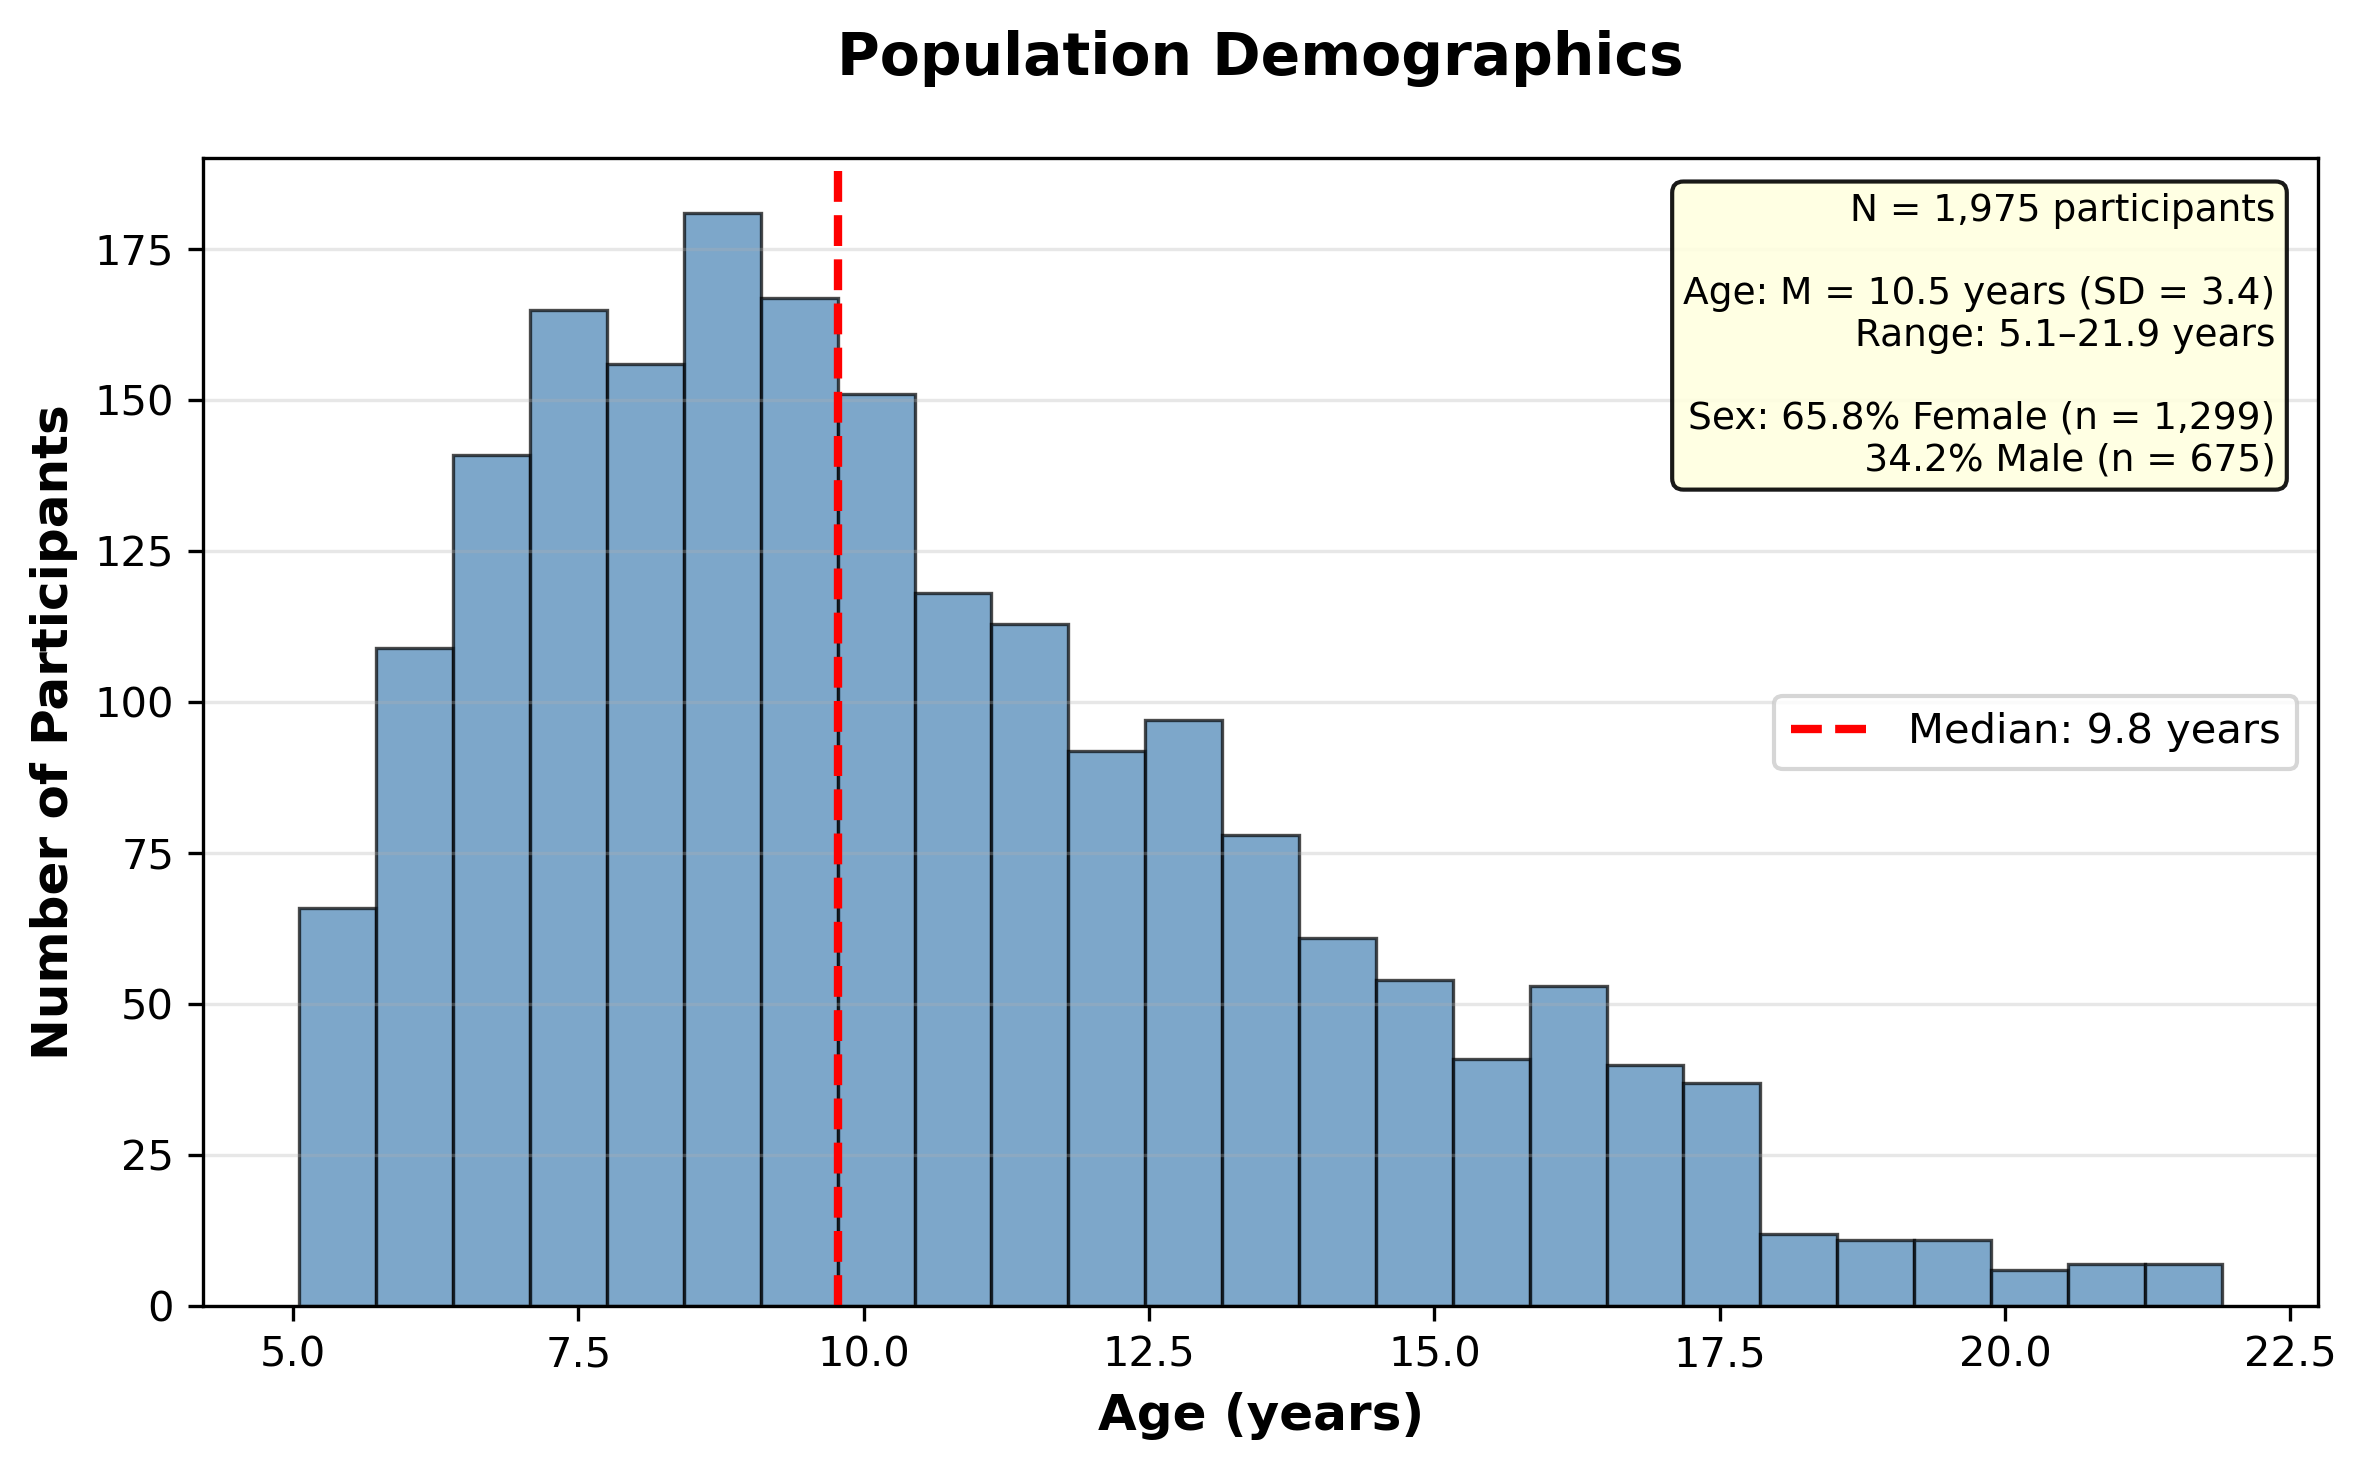

In [40]:
summary_cols = ["Age", "Sex"]
summary_cols = [c for c in summary_cols if c in core_view.columns]

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Age distribution as main plot
age_data = core_view["Age"].dropna()

# Histogram with customized appearance
n, bins, patches = ax.hist(age_data, bins=25, alpha=0.7, color='steelblue', 
                           edgecolor='black', linewidth=0.8)

# Add median line
median_age = age_data.median()
ax.axvline(median_age, color='red', linestyle='--', linewidth=2, 
          label=f'Median: {median_age:.1f} years')

# Styling
ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax.set_title('Population Demographics', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add comprehensive stats box
sex_data = core_view["Sex"].dropna()
n_female = (sex_data == 0).sum()
n_male = (sex_data == 1).sum()
pct_female = 100 * n_female / len(sex_data)
pct_male = 100 * n_male / len(sex_data)

stats_text = f'N = {len(core_view):,} participants\n\n'
stats_text += f'Age: M = {age_data.mean():.1f} years (SD = {age_data.std():.1f})\n'
stats_text += f'Range: {age_data.min():.1f}–{age_data.max():.1f} years\n\n'
stats_text += f'Sex: {pct_female:.1f}% Female (n = {n_female:,})\n'
stats_text += f'     {pct_male:.1f}% Male (n = {n_male:,})'

ax.text(0.98, 0.97, stats_text,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightyellow', 
                 alpha=0.9, edgecolor='black', linewidth=1))

plt.tight_layout()

---

## Summary of outputs:
- `data/interim/HBN_pheno_with_diagnosis.csv` - Phenotype + diagnosis data
- `data/interim/NIH_TempDisc_pheno.csv` - All data merged
- `data/interim/NIH_TempDisc_pheno_withTD.csv` - Add TD features
- `data/processed/hbn_core_view_v1.csv` - Analysis-ready core dataset
- `data/processed/hbn_extended_view_v1.csv` - Analysis-ready extended dataset

**Next steps:**
- Use the core/extended views for statistical analyses
- Build predictive models
- Create visualizations
- Run group comparisons